In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import tensorflow.keras.backend as K

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images_path = os.getcwd() + "/drive/MyDrive/Train Data/images/"
masks_path =  os.getcwd() + "/drive/MyDrive/Train Data/mask_result/"
images = os.listdir(images_path)
masks = os.listdir(masks_path)

# New Section

In [ ]:
dataset = pd.read_csv('drive/MyDrive/Train Data/train_data.csv')

In [ ]:
dataset.head()

,Image,Mask
0,ONB_aze_18950706_2.jpg,Mask_ONB_aze_18950706_2.jpg
1,ONB_aze_18950706_4.jpg,Mask_ONB_aze_18950706_4.jpg
2,ONB_aze_19110701_004.jpg,Mask_ONB_aze_19110701_004.jpg
3,ONB_aze_19110701_005.jpg,Mask_ONB_aze_19110701_005.jpg
4,ONB_aze_19110701_007.jpg,Mask_ONB_aze_19110701_007.jpg


In [ ]:
train_length = len(os.listdir(images_path))
batch_size = 8
buffer_size = 10
steps_per_epoch = train_length // batch_size
channels = 3
height = 512
width = 512

In [ ]:
from skimage.transform import resize
from tqdm import tqdm
import sys

In [ ]:
def image_generator(dataset,image_path,mask_path,train_length,img_shape):

  height,width,channels = img_shape
  X_train = np.zeros((train_length, height, width, channels), dtype=np.uint8)
  Y_train = np.zeros((train_length, height, width, 1), dtype=np.bool)

  sys.stdout.flush()

  for n in tqdm(range(train_length), total=train_length):

    img = plt.imread(image_path + dataset.iloc[n][0])[:,:,:channels]
    img_resized = resize(img, (height, width), mode='constant', preserve_range=True)
    X_train[n] = img_resized

    mask = plt.imread(mask_path + dataset.iloc[n][1])[:,:,:1]
    mask_resized = resize(mask, (height, width), mode='constant', preserve_range=True)
    Y_train[n] = mask_resized

  return X_train,Y_train

In [ ]:
X_train,Y_train = image_generator(dataset,images_path,masks_path,train_length,(height,width,channels))
Y_train = Y_train.astype(np.float32)

100%|██████████| 40/40 [02:39<00:00,  3.98s/it]


In [ ]:
#Creating the Model

In [ ]:
output_channels = 1
channels = 3
height = 512
width = 512

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[height, width, channels], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[height, width, channels])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  x = tf.keras.layers.UpSampling2D((2,2))(x)
  last = tf.keras.layers.Conv2D(1, (1,1), activation = "sigmoid")

  x = last(x)
  
  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model_t = unet_model(output_channels)
model_t.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 256, 256, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 512)  1476608     functional_1[0][4]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 512)  0           sequential[0][0]                 
_______________________________________________________________________________________

In [ ]:
def dice_coef(y_true,y_pred,epsilon=0.001):
  y_true_sum  = K.sum(y_true)
  y_pred_sum  = K.sum(y_pred)
  intersection = K.sum(y_true * y_pred)
  return ((2 * intersection + epsilon)/(y_true_sum + y_pred_sum + epsilon))

def dice_coef_loss(y_true,y_pred):
    return  1 - dice_coef(y_true,y_pred)

In [ ]:
epochs = 100
steps_per_epoch = len(X_train) // batch_size
batch_size = 8

In [ ]:
model_path = os.getcwd() + "/drive/MyDrive/Train Data/text_block_model_transfer.h5"

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,log={}):
    if (log.get('loss') < 0.020):
      self.model.stop_training = True


checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

callback = myCallback()

In [ ]:
model_t.compile(optimizer = 'adam', loss = dice_coef_loss , metrics = ["accuracy",dice_coef])
results = model_t.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs= epochs, callbacks = [checkpoint,callback])

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.5496 - dice_coef: 0.6259
Epoch 00001: val_loss improved from inf to 0.13337, saving model to /content/drive/MyDrive/Train Data/text_block_model_transfer.h5
5/5 [==============================] - 4s 848ms/step - loss: 0.3884 - accuracy: 0.5496 - dice_coef: 0.6259 - val_loss: 0.1334 - val_accuracy: 0.8669 - val_dice_coef: 0.8666
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.8266 - dice_coef: 0.8301
Epoch 00002: val_loss improved from 0.13337 to 0.05597, saving model to /content/drive/MyDrive/Train Data/text_block_model_transfer.h5
5/5 [==============================] - 2s 374ms/step - loss: 0.1744 - accuracy: 0.8266 - dice_coef: 0.8301 - val_loss: 0.0560 - val_accuracy: 0.9355 - val_dice_coef: 0.9440
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9079 - dice_coef: 0.8948
Epoch 00003: val_loss improved from 0.05597 to 0.

In [ ]:
loss = results.history['loss']
dice_coeff = results.history['dice_coef']
accuracy = results.history['accuracy']
val_loss = results.history['val_loss']
val_dice_coeff = results.history['val_dice_coef']
val_accuracy = results.history['val_accuracy']

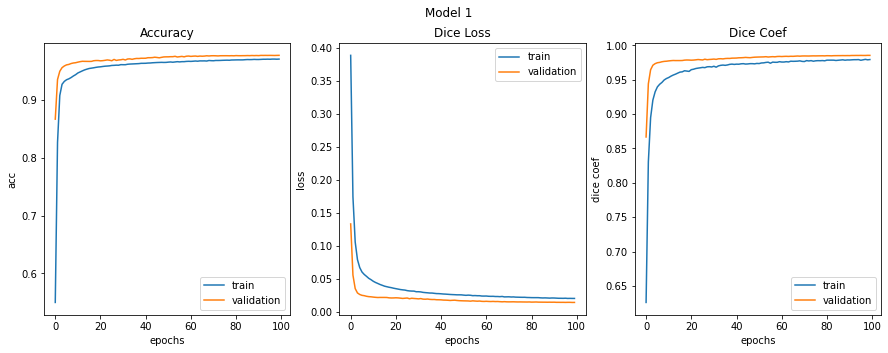

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(accuracy,label='training accuracy')
plt.plot(val_accuracy,label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['train','validation'])
plt.title('Accuracy')
plt.subplot(132)
plt.plot(loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.title('Dice Loss')
plt.subplot(133)
plt.plot(dice_coeff,label='training dice coef')
plt.plot(val_dice_coeff,label='validation dice coef')
plt.xlabel('epochs')
plt.ylabel('dice coef')
plt.legend(['train','validation'])
plt.title('Dice Coef')
plt.suptitle('Model 1')
plt.savefig( os.getcwd() + "/drive/MyDrive/Train Data/model1.jpg")

In [ ]:
test_path = os.getcwd() + "/drive/MyDrive/Train Data/test data/"
test_images = os.listdir(test_path)

In [ ]:
img = plt.imread(test_path + test_images[0] )[:,:,:channels]
img_resized = resize(img, (height, width), mode='constant', preserve_range=True)
img_test = img_resized.reshape((1,height,width,channels)).astype(np.uint8)

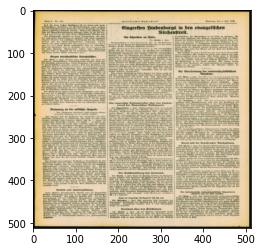

In [ ]:
plt.imshow(img_test.squeeze())

In [ ]:
mask_predicted = model_t.predict(img_test)

In [ ]:
mask_predicted = (mask_predicted > 0.5).astype(np.uint8)

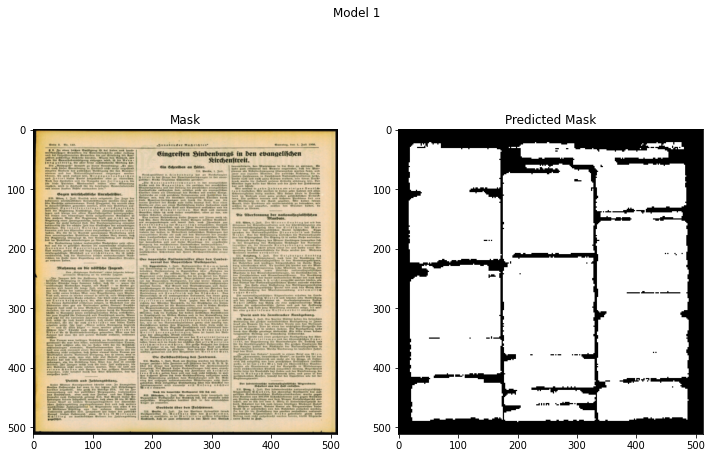

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(img_test.squeeze(),cmap='gray')
plt.title('Mask')
plt.subplot(122)
plt.imshow(mask_predicted.squeeze(),cmap='gray')
plt.title('Predicted Mask')
plt.suptitle('Model 1')
plt.savefig( os.getcwd() + "/drive/MyDrive/Train Data/model1_pred.jpg")

In [ ]:
#U-net Model from scratch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, concatenate
from tensorflow.keras.layers import Activation, BatchNormalization


In [ ]:
def unet(input_size=(256,256,3)):
    
    inputs = Input(input_size)
    x = Lambda(lambda x: x / 255)(inputs)
    
    #Contracting Path
    down_block_0_layer_0 = Conv2D(16,kernel_size=(3,3),padding="same")(x)
    down_block_0_layer_0 = Activation("relu")(down_block_0_layer_0)
    down_block_0_layer_1 = Conv2D(16,kernel_size=(3,3),padding='same')(down_block_0_layer_0)
    down_block_0_layer_1 = BatchNormalization(axis=3)(down_block_0_layer_1)
    down_block_0_layer_1 = Activation("relu")(down_block_0_layer_1)
    down_block_0_pool = MaxPool2D((2,2),strides=(2,2))(down_block_0_layer_1)
    
    down_block_1_layer_0 = Conv2D(32,kernel_size=(3,3),padding="same")(down_block_0_pool)
    down_block_1_layer_0 = Activation("relu")(down_block_1_layer_0)
    down_block_1_layer_1 = Conv2D(32,kernel_size=(3,3),padding='same')(down_block_1_layer_0)
    down_block_1_layer_1 = BatchNormalization(axis=3)(down_block_1_layer_1)
    down_block_1_layer_1 = Activation("relu")(down_block_1_layer_1)
    down_block_1_pool = MaxPool2D((2,2),strides=(2,2))(down_block_1_layer_1)
    
    down_block_2_layer_0 = Conv2D(64,kernel_size=(3,3),padding="same")(down_block_1_pool)
    down_block_2_layer_0 = Activation("relu")(down_block_2_layer_0)
    down_block_2_layer_1 = Conv2D(64,kernel_size=(3,3),padding='same')(down_block_2_layer_0)
    down_block_2_layer_1 = BatchNormalization(axis=3)(down_block_2_layer_1)
    down_block_2_layer_1 = Activation("relu")(down_block_2_layer_1)
    down_block_2_pool = MaxPool2D((2,2),strides=(2,2))(down_block_2_layer_1)
    
    down_block_3_layer_0 = Conv2D(128,kernel_size=(3,3),padding="same")(down_block_2_pool)
    down_block_3_layer_0 = Activation("relu")(down_block_3_layer_0)
    down_block_3_layer_1 = Conv2D(128,kernel_size=(3,3),padding='same')(down_block_3_layer_0)
    down_block_3_layer_1 = BatchNormalization(axis=3)(down_block_3_layer_1)
    down_block_3_layer_1 = Activation("relu")(down_block_3_layer_1)
    down_block_3_pool = MaxPool2D((2,2),strides=(2,2))(down_block_3_layer_1)
    
    down_block_4_layer_0 = Conv2D(256,kernel_size=(3,3),padding="same")(down_block_3_pool)
    down_block_4_layer_0 = Activation("relu")(down_block_4_layer_0)
    down_block_4_layer_1 = Conv2D(256,kernel_size=(3,3),padding='same')(down_block_4_layer_0)
    down_block_4_layer_1 = BatchNormalization(axis=3)(down_block_4_layer_1)
    down_block_4_layer_1 = Activation("relu")(down_block_4_layer_1)
    
    #Expanding Path
    up_block_0_upsample =  UpSampling2D((2,2))(down_block_4_layer_1)
    concat_block_0 =  concatenate([up_block_0_upsample,down_block_3_layer_1],axis=3)
    up_block_0_layer_0 = Conv2D(128,kernel_size=(3,3),padding="same")(concat_block_0)
    up_block_0_layer_0 = Activation("relu")(up_block_0_layer_0)
    up_block_0_layer_1 = Conv2D(128,kernel_size=(3,3),padding='same')(up_block_0_layer_0)
    up_block_0_layer_1 = BatchNormalization(axis=3)(up_block_0_layer_1)
    up_block_0_layer_1 = Activation("relu")(up_block_0_layer_1)
    
    up_block_1_upsample =  UpSampling2D((2,2))(up_block_0_layer_1)
    concat_block_1 =  concatenate([up_block_1_upsample,down_block_2_layer_1],axis=3)
    up_block_1_layer_0 = Conv2D(64,kernel_size=(3,3),padding="same")(concat_block_1)
    up_block_1_layer_0 = Activation("relu")(up_block_1_layer_0)
    up_block_1_layer_1 = Conv2D(64,kernel_size=(3,3),padding='same')(up_block_1_layer_0)
    up_block_1_layer_1 = BatchNormalization(axis=3)(up_block_1_layer_1)
    up_block_1_layer_1 = Activation("relu")(up_block_1_layer_1)
    
    up_block_2_upsample =  UpSampling2D((2,2))(up_block_1_layer_1)
    concat_block_2 =  concatenate([up_block_2_upsample,down_block_1_layer_1],axis=3)
    up_block_2_layer_0 = Conv2D(32,kernel_size=(3,3),padding="same")(concat_block_2)
    up_block_2_layer_0 = Activation("relu")(up_block_2_layer_0)
    up_block_2_layer_1 = Conv2D(32,kernel_size=(3,3),padding='same')(up_block_2_layer_0)
    up_block_2_layer_1 = BatchNormalization(axis=3)(up_block_2_layer_1)
    up_block_2_layer_1 = Activation("relu")(up_block_2_layer_1)
    
    up_block_3_upsample =  UpSampling2D((2,2))(up_block_2_layer_1)
    concat_block_3 =  concatenate([up_block_3_upsample,down_block_0_layer_1],axis=3)
    up_block_3_layer_0 = Conv2D(16,kernel_size=(3,3),padding="same")(concat_block_3)
    up_block_3_layer_0 = Activation("relu")(up_block_3_layer_0)
    up_block_3_layer_1 = Conv2D(16,kernel_size=(3,3),padding='same')(up_block_3_layer_0)
    up_block_3_layer_1 = BatchNormalization(axis=3)(up_block_3_layer_1)
    up_block_3_layer_1 = Activation("relu")(up_block_3_layer_1)
        

    outputs = Conv2D(1,(1,1),activation="sigmoid")(up_block_3_layer_1)
    
    return Model(inputs = [inputs], outputs = [outputs])

In [ ]:
model = unet(input_size=(height,width,channels))
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 512, 512, 16) 0           conv2d_20[0][0]                  
_______________________________________________________________________________________

In [ ]:
epochs = 100
steps_per_epoch = train_length // batch_size
batch_size = 8
learning_rate = 1e-4

In [ ]:
model_path = os.getcwd() + "/drive/MyDrive/Train Data/text_block_model_scratch.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

decay_rate = learning_rate / epochs
opt = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

In [ ]:
model.compile(optimizer=opt,loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
results_2 = model.fit(X_train, Y_train, validation_split=0.1,batch_size=batch_size, epochs=epochs,callbacks=[checkpoint])

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.4138 - dice_coef: 0.5904 - accuracy: 0.4739
Epoch 00001: val_loss improved from inf to 0.39090, saving model to /content/drive/MyDrive/Train Data/text_block_model_scratch.h5
5/5 [==============================] - 4s 842ms/step - loss: 0.4138 - dice_coef: 0.5904 - accuracy: 0.4739 - val_loss: 0.3909 - val_dice_coef: 0.6091 - val_accuracy: 0.1715
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.3348 - dice_coef: 0.6671 - accuracy: 0.6426
Epoch 00002: val_loss improved from 0.39090 to 0.39087, saving model to /content/drive/MyDrive/Train Data/text_block_model_scratch.h5
5/5 [==============================] - 2s 352ms/step - loss: 0.3348 - dice_coef: 0.6671 - accuracy: 0.6426 - val_loss: 0.3909 - val_dice_coef: 0.6091 - val_accuracy: 0.1764
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.3048 - dice_coef: 0.6952 - accuracy: 0.7000
Epoch 00003: val_loss did not improve from 0.39087


In [ ]:
test_path = os.getcwd() + "/drive/MyDrive/Train Data/test data/"
test_images = os.listdir(test_path)

In [ ]:
img = plt.imread(test_path + test_images[0] )[:,:,:channels]
img_resized = resize(img, (height, width), mode='constant', preserve_range=True)
img_test = img_resized.reshape((1,height,width,channels)).astype(np.uint8)
pred = model.predict(img_test)
pred = (pred > 0.5).astype(np.uint8)

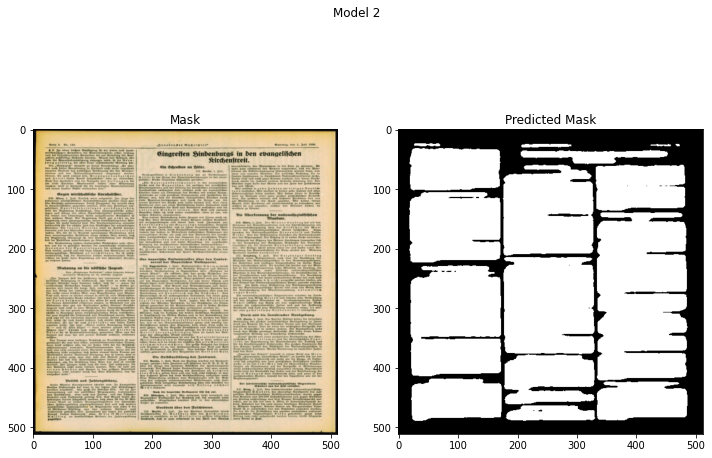

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(img_test.squeeze(),cmap='gray')
plt.title('Mask')
plt.subplot(122)
plt.imshow(pred.squeeze(),cmap='gray')
plt.title('Predicted Mask')
plt.suptitle('Model 2')
plt.savefig( os.getcwd() + "/drive/MyDrive/Train Data/model2_pred.jpg")

In [ ]:
loss_2 = results_2.history['loss']
dice_coeff_2 = results_2.history['dice_coef']
accuracy_2 = results_2.history['accuracy']
val_loss_2 = results_2.history['val_loss']
val_dice_coeff_2 = results_2.history['val_dice_coef']
val_accuracy_2 = results_2.history['val_accuracy']

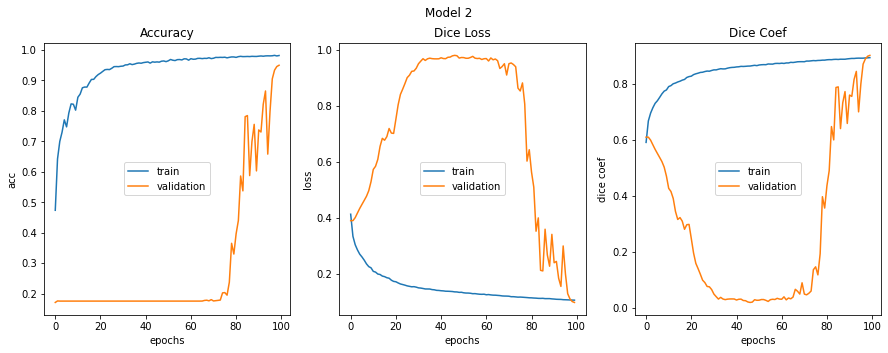

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(accuracy_2,label='training accuracy')
plt.plot(val_accuracy_2,label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['train','validation'])
plt.title('Accuracy')
plt.subplot(132)
plt.plot(loss_2,label='training loss')
plt.plot(val_loss_2,label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.title('Dice Loss')
plt.subplot(133)
plt.plot(dice_coeff_2,label='training dice coef')
plt.plot(val_dice_coeff_2,label='validation dice coef')
plt.xlabel('epochs')
plt.ylabel('dice coef')
plt.legend(['train','validation'])
plt.title('Dice Coef')
plt.suptitle('Model 2')
plt.savefig( os.getcwd() + "/drive/MyDrive/Train Data/model2.jpg")

# **Testing**

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import tensorflow.keras.backend as K
import sys
from tqdm import  tqdm
from skimage.transform import resize

In [13]:
dataset_path = "/content/drive/MyDrive/Train Data/test_data/"
image_path = dataset_path + "test_images/"
mask_path = dataset_path + "test_masks/"
img_shape = (512,512,3)

In [12]:
images = os.listdir(image_path)
masks  = os.listdir(mask_path)
images.sort()
masks.sort()
test_set = pd.DataFrame({'images': np.array(images),'masks':np.array(masks)})

In [2]:
def image_generator(dataset,image_path,mask_path,train_length,img_shape):

  height,width,channels = img_shape
  X_test = np.zeros((train_length, height, width, channels), dtype=np.uint8)
  Y_test = np.zeros((train_length, height, width, 1), dtype=np.bool)

  sys.stdout.flush()

  for n in tqdm(range(train_length), total=train_length):

    img = plt.imread(image_path + dataset.iloc[n][0])[:,:,:channels]
    img_resized = resize(img, (height, width), mode='constant', preserve_range=True)
    X_test[n] = img_resized

    mask = plt.imread(mask_path + dataset.iloc[n][1])[:,:,:1]
    mask_resized = resize(mask, (height, width), mode='constant', preserve_range=True)
    Y_test[n] = mask_resized

  return X_test,Y_test

In [29]:
X_test, Y_test = image_generator(test_set,image_path,mask_path,len(images),img_shape)
Y_test = Y_test.astype(np.float32)

100%|██████████| 5/5 [00:20<00:00,  4.15s/it]


In [3]:
def dice_coef(y_true,y_pred,epsilon=0.001):
  y_true_sum  = K.sum(y_true)
  y_pred_sum  = K.sum(y_pred)
  intersection = K.sum(y_true * y_pred)
  return ((2 * intersection + epsilon)/(y_true_sum + y_pred_sum + epsilon))

def dice_coef_loss(y_true,y_pred):
    return  1 - dice_coef(y_true,y_pred)

In [37]:
def test_results(images,masks,model):
  for image,mask in zip(images,masks):
    image = image.reshape(1,512,512,3)
    mask_pred = model.predict(image)
    mask_pred = (mask_pred > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(12,12))
    plt.subplot(131)
    plt.imshow(image.squeeze())
    plt.title("Text Document")
    plt.subplot(132)
    plt.imshow(mask.squeeze(),cmap='gray')
    plt.title("Original Mask")
    plt.subplot(133)
    plt.imshow(mask_pred.squeeze(),cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

In [46]:
model1_path = "/content/drive/MyDrive/Train Data/text_block_model_scratch.h5"
model2_path = "/content/drive/MyDrive/Train Data/text_block_model_transfer.h5"

In [47]:
model1 = tf.keras.models.load_model(model1_path,custom_objects={'dice_coef':dice_coef,'dice_coef_loss':dice_coef_loss})

In [48]:
results1 = model1.evaluate(X_test,Y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0969 - dice_coef: 0.9031 - accuracy: 0.9521


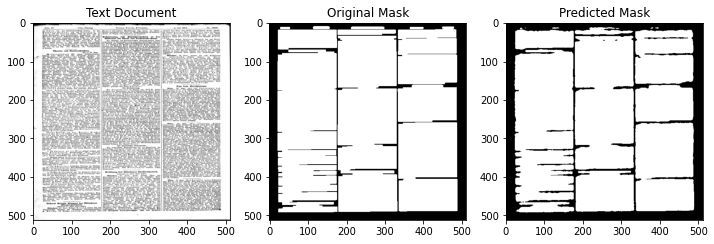

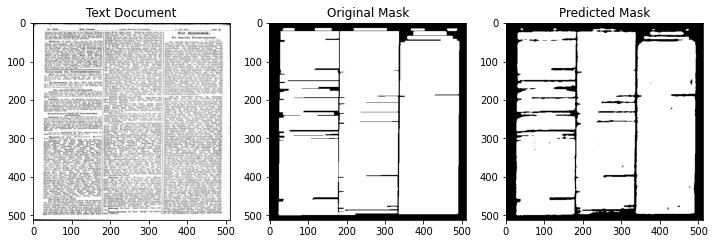

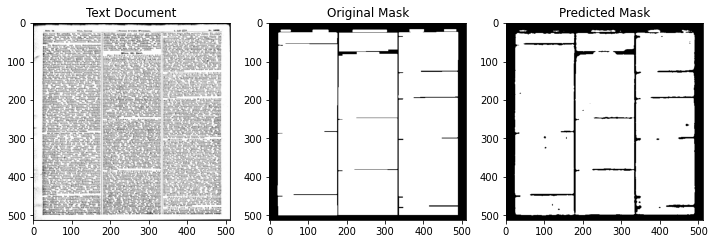

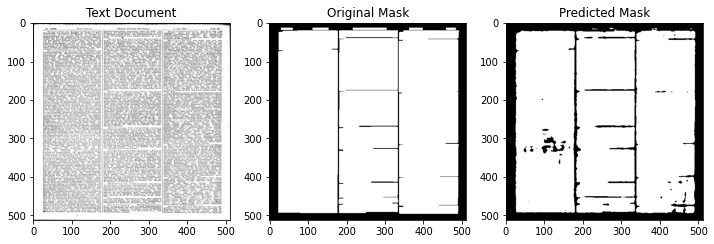

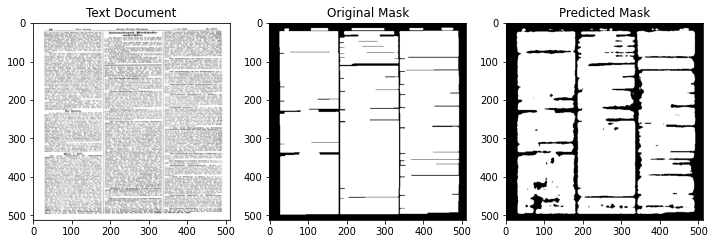

In [38]:
test_results(X_test,Y_test,model1)

In [50]:
model2 = tf.keras.models.load_model(model2_path,custom_objects={'dice_coef':dice_coef,'dice_coef_loss':dice_coef_loss})

In [51]:
results2 = model2.evaluate(X_test,Y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9766 - dice_coef: 0.9849


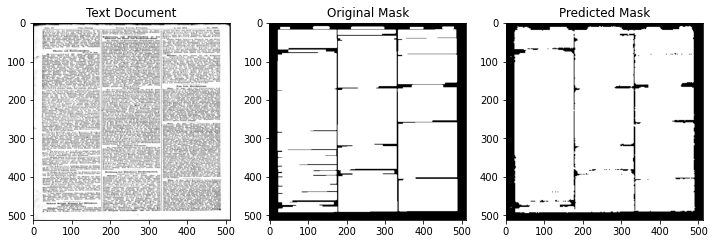

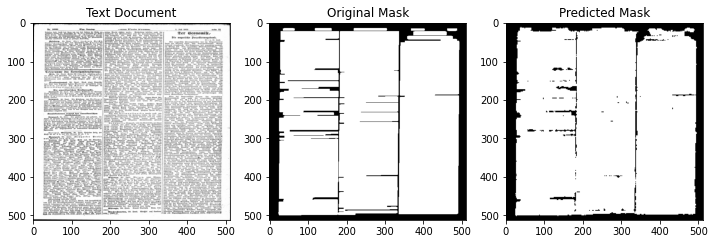

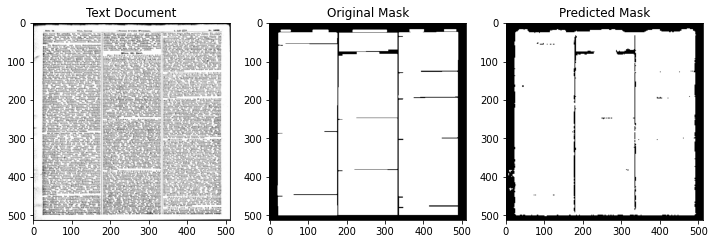

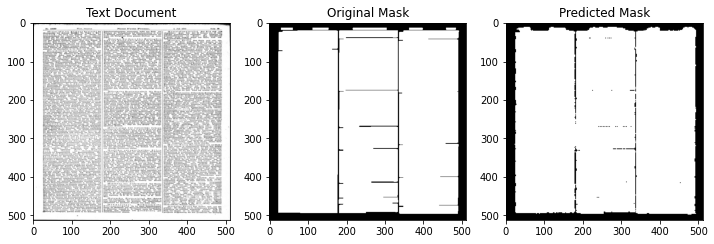

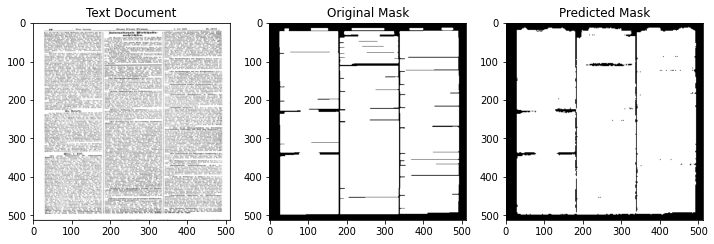

In [52]:
test_results(X_test,Y_test,model2)